<a href="https://colab.research.google.com/github/sjnaj/DeepLearning/blob/master/Convolution/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VGG

经典卷积神经网络的基本组成部分是下面的这个序列：

- 带填充以保持分辨率的卷积层；

- 非线性激活函数，如ReLU；

- 汇聚层，如最大汇聚层。

而一个VGG块与之类似，由一系列卷积层组成，后面再加上用于空间下采样的最大汇聚层

在最初的VGG论文中，作者使用了带有卷积核、填充为1（保持高度和宽度）的卷积层，和带有汇聚窗口、步幅为2（每个块后的分辨率减半）的最大汇聚层

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


<img src="http://d2l.ai/_images/vgg.svg">

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs,in_channels,out_channels):
  layers=[]
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
    layers.append(nn.ReLU())
    in_channels=out_channels#第一个卷积层将输入通道数为输出通道数，其余的都等于输出通道数
  layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
  return nn.Sequential(*layers)



原始VGG网络有5个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。
第一个模块有64个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到512。由于该网络使用8个卷积层和3个全连接层，因此它通常被称为VGG-11。

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [5]:
def vgg(conv_arch):
  conv_blks=[]
  in_channels=1#初始通道数
  #卷积层部分
  for (num_convs,out_channels) in conv_arch:
    conv_blks.append(vgg_block(num_convs,in_channels,out_channels))
    in_channels=out_channels
  return nn.Sequential(
      *conv_blks,

      #全连接部分
      nn.Flatten(),
      nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(0.5),
      nn.Linear(4096,10)
      
  )

In [6]:
net=vgg(conv_arch)

In [7]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


[**由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络**]，足够用于训练Fashion-MNIST数据集。

In [8]:
radio=4
small_conv_arch=[(pair[0],pair[1]//radio) for pair in conv_arch]
net=vgg(small_conv_arch)

loss 0.180, train acc 0.934, test acc 0.915
1244.2 examples/sec on cuda:0


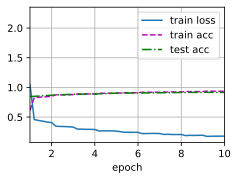

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())